## 初始化

In [17]:
import sys,os 
root_path = os.path.abspath('../../../../')
sys.path.append(root_path)
root_path

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import src.features.factors.consolidate_factor as cf
import src.visualization.plotting as pt

## 整理数据

In [11]:
fp = root_path + "/xxx.parquet"  # 需要用到的其它类型的数据
mf = pd.read_parquet(fp)

In [12]:
md_fp = root_path + "/data/example/IF/md.parquet"  # 需要用到的行情数据
md = pd.read_parquet(md_fp)

In [ ]:
df = pd.concat([mf, md], axis=1).dropna(axis=0)  # 将数据源进行整合

In [14]:
df['return'] = df['close'].diff()  # 基准收益

## 生成因子

## 设置因子的类型、名称、参数值

In [1]:
factor_type = 'tmom'
factor_signature = 'xxx'
param_signatures = [560, 720, 960, 1200, 1800]
raw_factor_name = f"factor_{factor_type}_{factor_signature}"
raw_factor_name

'factor_tmom_xxx'

In [15]:
def factor_tmom_xxx(df: pd.DataFrame, w) -> pd.Series:
    """
    最好在这里规范描述因子逻辑，以便后期整理
    """
    df['factor'] = df['return'].rolling(w).mean() / df['return'].rolling(w).max()  # 生成因子
    return df['factor']

## 开启一个循环，用以检验因子在不同参数下的表现

In [57]:
# set signal shift
sig_shift = 1

In [58]:
compare_df, compare_df_2 = pd.DataFrame(), pd.DataFrame()
for i in param_signatures:
    factor = factor_tmom_NMF_NETBS(df, i)
    signal = np.sign(factor)
    ret_cumsum_df = pd.DataFrame((df['return'] * signal.shift(sig_shift)).cumsum(), columns=[i])
    ret_df = pd.DataFrame((df['return'] * signal.shift(sig_shift)), columns=[i])
    compare_df = pd.concat([compare_df, ret_cumsum_df], axis=1)
    compare_df_2 = pd.concat([compare_df_2, ret_df], axis=1)
compare_df['benchmark'] = base_return.cumsum()
compare_df['close'] = df['close']
compare_df_2['benchmark'] = base_return

<AxesSubplot:xlabel='datetime'>

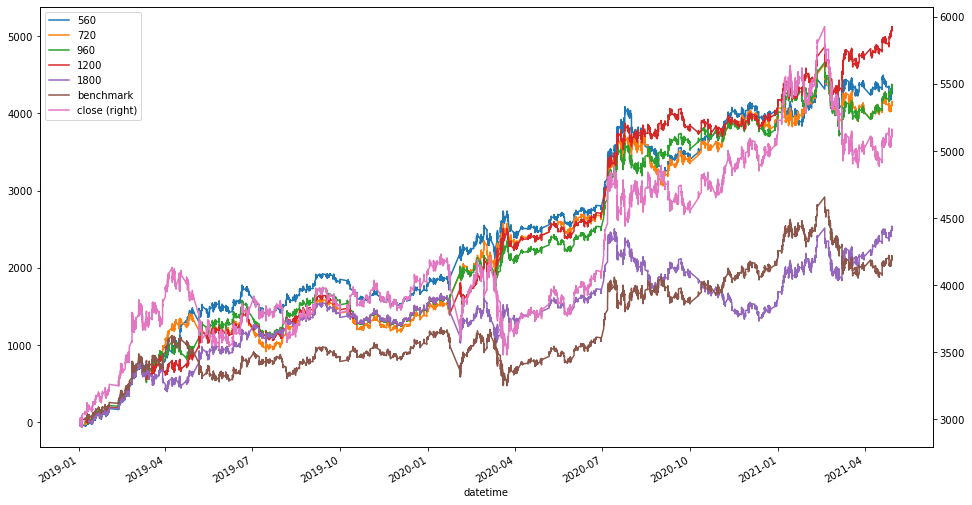

In [59]:
compare_df.plot(figsize=(16,9), secondary_y='close')

<AxesSubplot:>

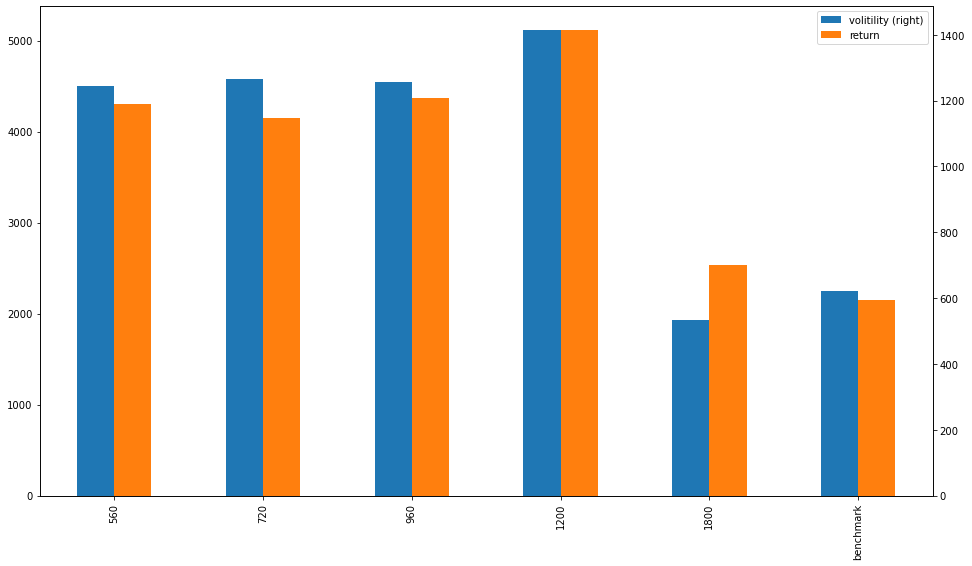

In [60]:
compare_df.drop(columns=['close'], inplace=True)
vol_on_return = pd.DataFrame((compare_df - compare_df.mean()).std(), columns=['volitility'])
final_return = pd.DataFrame(compare_df.iloc[-1])
final_return.columns = ['return']
sample_df = pd.concat([vol_on_return, final_return], axis=1)
sample_df.plot(kind='bar', secondary_y='volitility', figsize=(16,9))

In [61]:
compare_df.describe()

,560,720,960,1200,1800,benchmark
count,129291.000000,129131.000000,128891.00000,128651.000000,128051.000000,129850.000000
mean,2471.994109,2295.423347,2305.70879,2402.465046,1437.950195,1215.734916
std,1243.960967,1264.931148,1256.41206,1415.374465,532.819646,622.679346
min,-52.600000,-30.400000,-8.00000,-14.000000,-22.600000,-66.000000
25%,1562.200000,1244.900000,1309.60000,1293.600000,1221.200000,789.600000
50%,2360.400000,2133.200000,2014.20000,1946.600000,1429.800000,964.400000
75%,3731.700000,3578.200000,3660.90000,3837.600000,1793.100000,1748.000000
max,4505.600000,4640.600000,4662.80000,5126.200000,2538.800000,2917.600000


In [63]:
compare_df_2.describe()

,560,720,960,1200,1800,benchmark
count,129291.000000,129131.000000,128891.000000,128651.000000,128051.000000,129850.000000
mean,0.033299,0.032158,0.033931,0.039799,0.019780,0.016550
std,3.824754,3.826909,3.829847,3.832592,3.838385,3.822346
min,-137.000000,-137.000000,-118.800000,-118.800000,-321.200000,-321.200000
25%,-1.600000,-1.600000,-1.600000,-1.600000,-1.600000,-1.600000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000
max,321.200000,321.200000,321.200000,321.200000,197.800000,142.000000


## 选取你认为表现比较好的因子，将因子函数固化

In [16]:
param_signature = 1200
factor_name = f"factor_{factor_type}_{factor_signature}_{param_signature}"
factor_name

'factor_tmom_xxx_1200'

#### 现在，你的因子函数应该有固定的参数，而非传入参数。

In [65]:
def factor_tmom_xxx_1200(df: pd.DataFrame):
    """
    衡量北向资金净买入量在1200期内的投票结果
    """
    df['factor'] = df['return'].rolling(w).mean() / df['return'].rolling(w).max()  # 生成因子
    return df['factor']

In [66]:
factor = factor_tmom_NMF_NETBS_1200(df)

## 再次对固化的因子进行回测检验

In [67]:
# set signal shift
sig_shift = 1

## 确认因子转换为信号的逻辑

In [68]:
signal = np.sign(factor)

## 确认回测结果

In [69]:
(df['return'] * signal.shift(sig_shift)).cumsum().describe()

count    128651.000000
mean       2402.465046
std        1415.374465
min         -14.000000
25%        1293.600000
50%        1946.600000
75%        3837.600000
max        5126.200000
dtype: float64

<AxesSubplot:xlabel='datetime'>

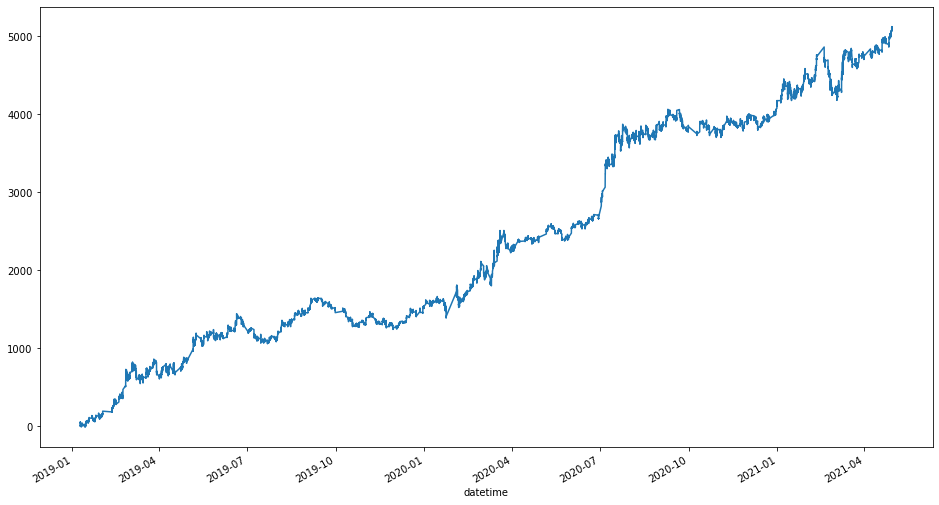

In [70]:
(df['return'] * signal.shift(sig_shift)).cumsum().plot(figsize=(16,9))

<AxesSubplot:xlabel='factor', ylabel='return'>

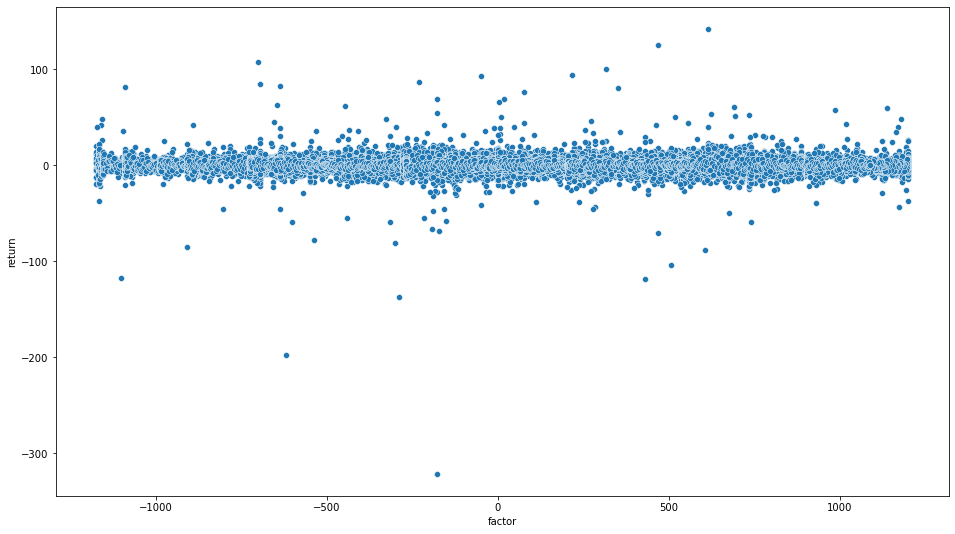

In [71]:
data = pd.DataFrame([factor.shift(sig_shift), base_return]).T
data.columns = ['factor', 'return']
fig = plt.figure(figsize=(16,9))
sns.scatterplot(data=data, x='factor', y='return')

<AxesSubplot:xlabel='signal', ylabel='return'>

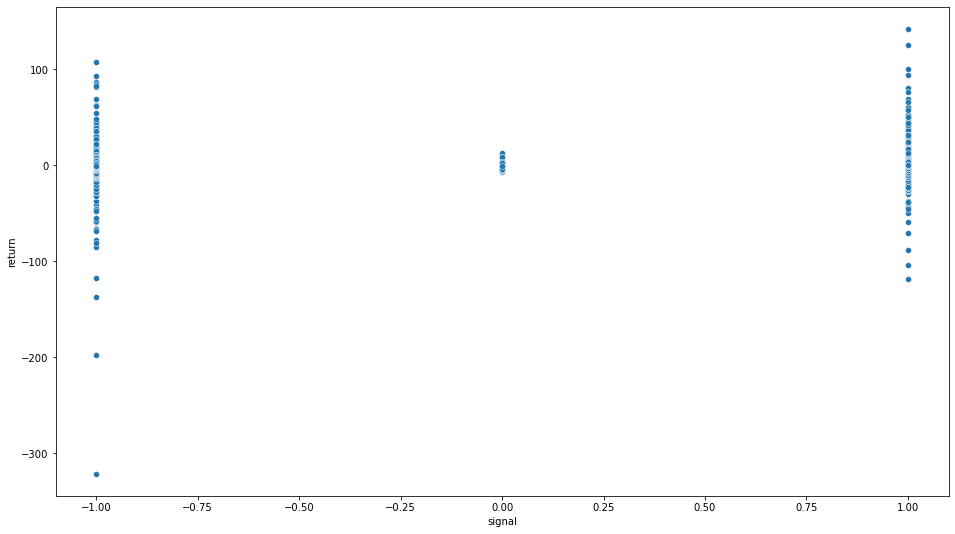

In [72]:
data = pd.DataFrame([signal.shift(sig_shift), base_return]).T
data.columns = ['signal', 'return']
fig = plt.figure(figsize=(16,9))
sns.scatterplot(data=data, x='signal', y='return')

-----------------

# <font color=red>CAUTION! </font>
#### <font color=red>YOU ARE ABOUT TO CONSOLIDATE A FACTOR FUNCTION AND ITS DATA. </font>
#### <font color=red>ENTER FOLLOWING STEPS WITH CAUTION!</font>

-------------------------

## consolidate factor

In [73]:
cf.record_source(factor_tmom_NMF_NETBS_1200)

## set instrument name:

In [74]:
instrument = 'IF'

## save factor to parquet

In [80]:
factor_df = pd.DataFrame(factor)
factor_df.columns=['factor']
factor_df

,factor
datetime,
2019-01-02 09:31:00,NaN
2019-01-02 09:32:00,NaN
2019-01-02 09:33:00,NaN
2019-01-02 09:34:00,NaN
2019-01-02 09:35:00,NaN
...,...
2021-04-29 14:56:00,1086.0
2021-04-29 14:57:00,1086.0
2021-04-29 14:58:00,1088.0


In [81]:
factor_fp = root_path + f"/factor/{instrument}/"
# os.mkdir(factor_fp)
cf.save_factor(factor_df, factor_fp, factor_name)

## save signal to parquet

In [82]:
signal_df = pd.DataFrame(signal)
signal_df.columns=['signal']
signal_df

,signal
datetime,
2019-01-02 09:31:00,NaN
2019-01-02 09:32:00,NaN
2019-01-02 09:33:00,NaN
2019-01-02 09:34:00,NaN
2019-01-02 09:35:00,NaN
...,...
2021-04-29 14:56:00,1.0
2021-04-29 14:57:00,1.0
2021-04-29 14:58:00,1.0


In [83]:
signal_fp = root_path + f"/signal/{instrument}"
# os.mkdir(signal_fp)
cf.save_signal(signal_df, signal_fp, factor_name)